# Image Classification with Fashion MNIST

This project implements an image classification model on the Fashion MNIST dataset using transfer learning with MobileNetV2. The complete pipeline covers:
- Data preprocessing (resizing, normalization, augmentation)
- Exploratory data analysis (EDA)
- Model training with early stopping and learning rate scheduling
- Evaluation (accuracy, classification report, confusion matrix)
- Deployment as a REST API with FastAPI (with basic authentication) and a Streamlit-based frontend
- Bonus: Grad-CAM explainability and logging

*Note:* This notebook is intended to be run on Google Colab for model training and evaluation. Deployment code (API, Streamlit, Dockerfile, README) is provided in separate files to be used in a local or containerized environment.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models, applications, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import cv2
import os


In [2]:
# Load Fashion MNIST dataset from Keras
fashion_mnist = tf.keras.datasets.fashion_mnist
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

# Print basic info
print("Training samples:", X_train.shape)
print("Test samples:", X_test.shape)
print("Classes:", np.unique(y_train))


Training samples: (60000, 28, 28)
Test samples: (10000, 28, 28)
Classes: [0 1 2 3 4 5 6 7 8 9]


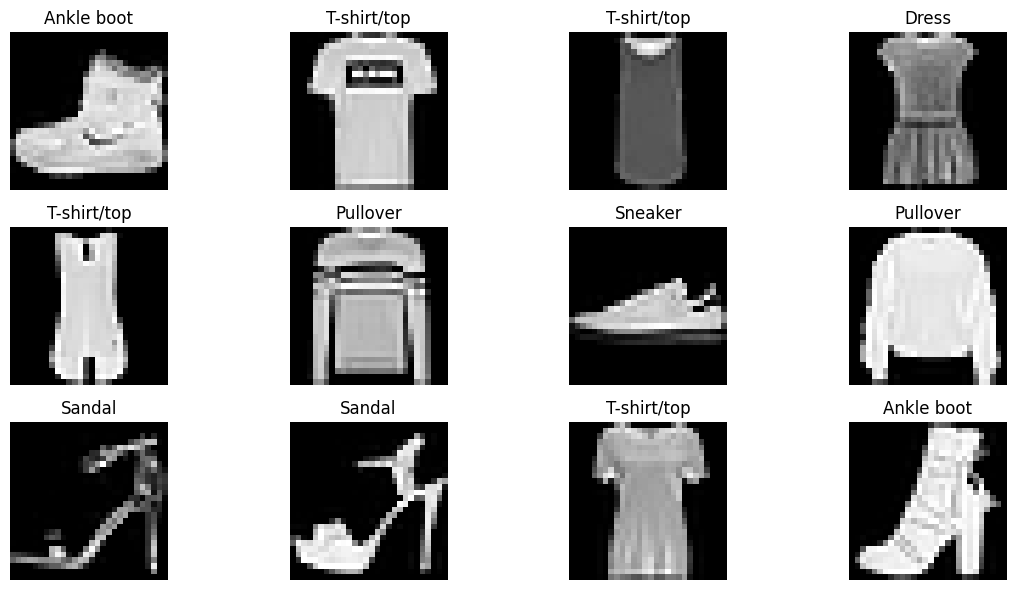

In [3]:
# Define class names
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Plot a few examples
plt.figure(figsize=(12, 6))
for i in range(12):
    plt.subplot(3, 4, i+1)
    plt.imshow(X_train[i], cmap='gray')
    plt.title(class_names[y_train[i]])
    plt.axis('off')
plt.tight_layout()
plt.show()


In [4]:
IMG_SIZE = 96

def preprocess_images_tf(images):
    # Convert images to a TensorFlow tensor and add channel dimension: (num_images, 28, 28, 1)
    images_tensor = tf.convert_to_tensor(images, dtype=tf.float32)
    images_tensor = tf.expand_dims(images_tensor, axis=-1)

    # Convert grayscale to RGB: (num_images, 28, 28, 3)
    images_rgb = tf.image.grayscale_to_rgb(images_tensor)

    # Resize images to (IMG_SIZE, IMG_SIZE) in a vectorized manner
    images_resized = tf.image.resize(images_rgb, (IMG_SIZE, IMG_SIZE))

    # Normalize images to the [0,1] range
    images_norm = images_resized / 255.0
    return images_norm

# Preprocess training and testing images using the vectorized function
X_train_processed = preprocess_images_tf(X_train)
X_test_processed = preprocess_images_tf(X_test)

print("Processed training shape:", X_train_processed.shape)
print("Processed test shape:", X_test_processed.shape)


Processed training shape: (60000, 96, 96, 3)
Processed test shape: (10000, 96, 96, 3)


In [5]:
# Create an ImageDataGenerator for augmentation
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    validation_split=0.1  # 10% of training data for validation
)

# For training generator: use augmented images
train_generator = train_datagen.flow(
    X_train_processed, y_train, subset='training', batch_size=32
)

# For validation generator: no augmentation
val_datagen = ImageDataGenerator(validation_split=0.1)
val_generator = val_datagen.flow(
    X_train_processed, y_train, subset='validation', batch_size=32
)


In [6]:
# Use MobileNetV2 as the base model with pre-trained ImageNet weights.
# Set include_top=False and use our custom classifier.
base_model = applications.MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                                       include_top=False,
                                       weights='imagenet')

# Freeze the base model
base_model.trainable = False

# Build the full model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(10, activation='softmax')  # 10 classes for Fashion MNIST
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_96             │ (None, 3, 3, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,270,794 (8.66 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [7]:
# Define callbacks: early stopping and learning rate reduction
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_reduce = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stop, lr_reduce]
)


c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 174s 100ms/step - accuracy: 0.7536 - loss: 0.7162 - val_accuracy: 0.8592 - val_loss: 0.3940 - learning_rate: 0.0010
Epoch 2/20
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 123s 73ms/step - accuracy: 0.8481 - loss: 0.4327 - val_accuracy: 0.8727 - val_loss: 0.3448 - learning_rate: 0.0010
Epoch 3/20
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 119s 70ms/step - accuracy: 0.8501 - loss: 0.4250 - val_accuracy: 0.8583 - val_loss: 0.3978 - learning_rate: 0.0010
Epoch 4/20
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 111s 66ms/step - accuracy: 0.8506 - loss: 0.4152 - val_accuracy: 0.8733 - val_loss: 0.3657 - learning_rate: 0.0010
Epoch 5/20
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.8490 - loss: 0.4211
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 106s 63ms/step - accuracy: 0.8490 - loss: 0.4211 - val_accuracy: 0.8768 - val_loss: 0.3484 - learning_rate: 0.0010
Epoch 6/20
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 125s 74ms/step - a

In [8]:
# Evaluate on the test set
test_loss, test_acc = model.evaluate(X_test_processed, y_test, verbose=2)
print("Test Accuracy: {:.2f}%".format(test_acc * 100))

# Generate predictions and classification report
y_pred_probs = model.predict(X_test_processed)
y_pred = np.argmax(y_pred_probs, axis=1)
print(classification_report(y_test, y_pred, target_names=class_names))


313/313 - 16s - 50ms/step - accuracy: 0.8701 - loss: 0.3537
Test Accuracy: 87.01%
313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step
              precision    recall  f1-score   support

 T-shirt/top       0.79      0.86      0.83      1000
     Trouser       0.99      0.96      0.98      1000
    Pullover       0.82      0.82      0.82      1000
       Dress       0.88      0.83      0.85      1000
        Coat       0.77      0.83      0.80      1000
      Sandal       0.97      0.94      0.95      1000
       Shirt       0.65      0.60      0.62      1000
     Sneaker       0.90      0.95      0.92      1000
         Bag       0.97      0.99      0.98      1000
  Ankle boot       0.96      0.94      0.94      1000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix

# Learning Rate Scheduler callback
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

# Re-train with learning rate scheduler included (if not already done)
model.fit(X_train_final, y_train_final, epochs=20,
          validation_data=(X_val, y_val),
          callbacks=[early_stopping, lr_scheduler])

# Predict on test set
y_pred_probs = model.predict(X_test_processed)
y_pred = np.argmax(y_pred_probs, axis=1)

# Classification Report & Confusion Matrix
print(classification_report(y_test, y_pred, target_names=class_names))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


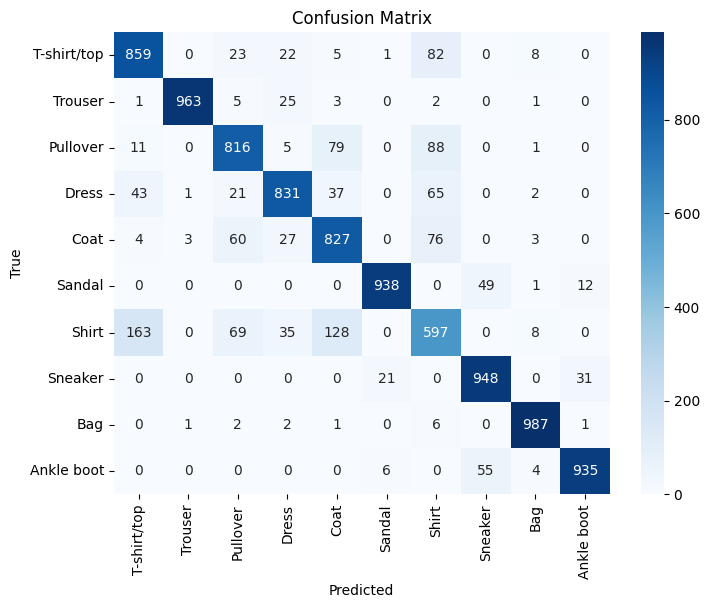

In [9]:
# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [10]:
# Create a directory to save the model if it doesn't exist
os.makedirs("model", exist_ok=True)
model.save("model/final_model.h5")
print("Model saved to model/final_model.h5")


Model saved to model/final_model.h5


In [19]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt

def make_gradcam_heatmap(img_array, model, base_model, last_conv_layer_name, pred_index=None):
    # Ensure the model is built by building it explicitly if not already built.
    if not model.built:
        model.build((None, IMG_SIZE, IMG_SIZE, 3))
    # Run a dummy prediction to define the model outputs.
    dummy_input = np.zeros((1, IMG_SIZE, IMG_SIZE, 3))
    _ = model.predict(dummy_input)
    
    # Get the desired convolutional layer from the base model.
    last_conv_layer = base_model.get_layer(last_conv_layer_name)
    
    # Create a model that maps the input image to both the last conv layer's output and the model's output.
    grad_model = tf.keras.models.Model(
        inputs=model.inputs,
        outputs=[last_conv_layer.output, model.output]
    )
    
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]
    
    # Compute gradients of the target class with respect to the conv layer output.
    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    # Process the conv outputs for the first image in the batch.
    conv_outputs = conv_outputs[0]
    conv_outputs *= pooled_grads
    heatmap = tf.reduce_sum(conv_outputs, axis=-1)
    
    # Apply ReLU and normalize the heatmap.
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# --- Example Usage ---

# Define the target image size (should match your preprocessing)
IMG_SIZE = 96

# Ensure your model is built. If not, build it with the expected input shape.
if not model.built:
    model.build((None, IMG_SIZE, IMG_SIZE, 3))
# Run a dummy prediction to initialize model outputs.
dummy_input = np.zeros((1, IMG_SIZE, IMG_SIZE, 3))
_ = model.predict(dummy_input)

# Extract the base model (assuming it was added as the first layer in your Sequential model).
base_model = model.get_layer('mobilenetv2_1.00_96')

# Specify the name of the convolutional layer to use for Grad-CAM.
# For MobileNetV2, "block_16_project" is a common choice.
last_conv_layer_name = "block_16_project"

# Select one preprocessed test image from your X_test_processed and expand its dimensions.
img = X_test_processed[0]
img_input = np.expand_dims(img, axis=0)

# Compute the Grad-CAM heatmap.
heatmap = make_gradcam_heatmap(img_input, model, base_model, last_conv_layer_name)

# Display the original image and the Grad-CAM overlay.
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
# Resize the heatmap to match the image dimensions.
heatmap_resized = cv2.resize(heatmap, (IMG_SIZE, IMG_SIZE))
plt.imshow(img)
plt.imshow(heatmap_resized, cmap='jet', alpha=0.5)
plt.title("Grad-CAM Overlay")
plt.axis('off')

plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


AttributeError: The layer sequential has never been called and thus has no defined output.